In [213]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from xgboost import XGBClassifier, plot_importance
from utils import manage_outlier

def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

warnings.filterwarnings('ignore')
seed_everything()

In [236]:
df = pd.read_csv('./dataset/ff.csv')

def make_targets(targets):
    return 1 if targets >=5 else 0

# df['BE3_31'] = df.apply(
#     lambda row: make_targets(row['BE3_31']), axis=1
# )
df['BE5_1'] = df.apply(
    lambda row: make_targets(row['BE5_1']), axis=1
)

df.head(3)

,HE_FEV1FVC,age,Total_slp_wk,sex,occp,EC1_1,cfam,marri_1,BH9_11,HE_DM,...,EC_pedu_1,EC_pedu_2,BS5_1,BD7_4,eq_5d,sm_present,mh_stress,cage,BE3_31,BE5_1
0,0.699366,74.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,NaN,NaN,비흡연자,없었음,0.720,1,1.0,7,7.0,0
1,0.698630,80.0,6.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,...,NaN,NaN,비흡연자,없었음,0.723,0,0.0,7,0.0,0
2,0.698466,49.0,8.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,무학,무학,언젠가금연,1년동안있었음,1.000,0,0.0,4,0.0,0


In [237]:
drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
display(drops[:10])
df = df[drops[drops.values <= 10].index]

drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
display(drops[:10])

HE_cough1    23.867550
HE_sput1     23.867550
EC_pedu_1    23.682119
EC_pedu_2    20.503311
HE_DM        16.529801
BD7_4        15.072848
BD7_5        13.086093
BH9_11       11.735099
BP6_10       10.728477
BP5          10.622517
dtype: float64

BS5_1      4.582781
occp       1.748344
EC1_1      1.589404
edu        1.589404
BE3_31     1.509934
LQ4_00     1.509934
LQ_4EQL    1.483444
LQ1_sb     1.456954
BH2_61     1.456954
LQ1_mn     1.456954
dtype: float64

In [238]:
# feature importance 기반 변수 제거(1차)
df.drop(['LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL'], axis=1, inplace=True)
# feature importance 기반 변수 제거(2차) X
# df.drop(['BS5_1'], axis=1, inplace=True)
# corr matrix 기반 변수 제거(3차)
df.drop(['EC1_1'], axis=1, inplace=True)
# feature importance 기반 변수 제거(4차) X
# df.drop(['D_1_1'], axis=1, inplace=True)
# feature importance 기반 변수 제거(5차)
df.drop(['cage', 'LQ1_sb', 'BP1', 'LQ1_mn'], axis=1, inplace=True)

In [239]:
# 1차년도
NUMERIC = ['HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
f_CATEGORICAL = (CATEGORICAL + CATEGORICAL2 + CATEGORICAL3).copy()
f_ONE_HOT = (ONE_HOT + ONE_HOT2 + ONE_HOT3).copy()

In [243]:
for value in f_NUMERIC:
    if value not in df.columns:
        print(value)
        f_NUMERIC.remove(value)

for value in f_CATEGORICAL:
    if value not in df.columns:
        print(value)
        f_CATEGORICAL.remove(value)

for value in f_ONE_HOT:
    if value not in df.columns:
        print(value)
        f_ONE_HOT.remove(value)

In [244]:
f_ONE_HOT.append('BE3_31')

In [245]:
# 결측치 처리
for col in df.columns:
    # df[col].fillna(df[col].mode()[0], inplace=True)
    df[col].fillna(0, inplace=True)

In [246]:
X = df.drop('BE5_1', axis=1)
y = df['BE5_1']

X_numeric = X[f_NUMERIC]
X_categorical = X[f_CATEGORICAL]
X_onehot = X[f_ONE_HOT]

In [247]:
# 원핫인코딩
# X_onehot['cage'].replace({
#     4:'40대',
#     5:'50대',
#     6:'60대',
#     7:'70대',
# }, inplace=True)
X_onehot['BE3_31'].replace({
    0:'0일',
    1:'1일',
    2:'2일',
    3:'3일',
    4:'4일',
    5:'5일',
    6:'6일',
    7:'7일',
}, inplace=True)
X_onehot = pd.get_dummies(X_onehot, dtype=float)

In [248]:
X = pd.concat([X_numeric, X_categorical], axis=1)
X = pd.concat([X, X_onehot], axis=1)

In [249]:
# split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
scaler = StandardScaler()
train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=scaler.feature_names_in_)
test_X = pd.DataFrame(scaler.transform(test_X), columns=scaler.feature_names_in_)

train_X = train_X.reset_index().drop('index', axis=1)
train_y = train_y.reset_index().drop('index', axis=1)

In [26]:
# param tuning(for oversampling)
def objective(trial:optuna.Trial, xdata, ydata):
    scores = []
    
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 200, 400),
        'max_depth' : trial.suggest_int('max_depth', 10, 20),
        'learning_rate' : trial.suggest_float('learning_rate', .001, .01),
        'gamma' : trial.suggest_float('gamma', 0, 20),
        'alpha' : trial.suggest_float('alpha', 0, 10),
        'lambda' : trial.suggest_float('lambda', 1, 20),
        'min_child_weight' : trial.suggest_float('min_child_weight', 0, 10),
        'max_delta_step' : trial.suggest_int('max_delta_step', 10, 50),
        'subsample' : trial.suggest_float('subsample', .1, 1),
        'sampling_method' : trial.suggest_categorical('sampling_method', ['uniform']),
        'tree_method' : trial.suggest_categorical('tree_method', ['hist', 'approx']),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'max_bin' : trial.suggest_int('max_bin', 256, 512),
        'scale_pos_weight' : trial.suggest_categorical('scale_pos_weight', [1, 8.09638554])
    }
    kf = StratifiedKFold(n_splits=5)
    for train_idx, val_idx in kf.split(xdata, ydata):
        tr_X = xdata.loc[train_idx]
        tr_y = ydata.loc[train_idx]

        adasyn = ADASYN(random_state=42)
        ada_X, ada_y = adasyn.fit_resample(tr_X.values, tr_y)
        ada_X = pd.DataFrame(ada_X, columns=tr_X.columns)
        
        val_X = xdata.loc[val_idx]
        val_y = ydata.loc[val_idx]
        
        model = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **param)    
        model.fit(ada_X, ada_y, verbose=False, eval_metric='error', eval_set=[(ada_X, ada_y),(val_X, val_y)])
        
        pred = model.predict(val_X)
        scores.append(f1_score(pred, val_y))
        
    return np.mean(scores)

In [27]:
study = optuna.create_study(direction='maximize')

study.optimize(lambda trial:objective(trial, train_X, train_y), n_trials=100)
print(f'Best trial: {study.best_trial}')
print(f'Best value: {study.best_value}')
print(f'Best params: {study.best_params}')

[I 2023-12-27 08:06:46,008] A new study created in memory with name: no-name-e6cddbe7-4621-4bca-9c26-cb2690cf80a6
[I 2023-12-27 08:06:56,749] Trial 0 finished with value: 0.31473947957470594 and parameters: {'n_estimators': 348, 'max_depth': 18, 'learning_rate': 0.007487229974645447, 'gamma': 13.564995219401377, 'alpha': 1.6968142091369876, 'lambda': 1.0059099025411273, 'min_child_weight': 0.4424533451079693, 'max_delta_step': 46, 'subsample': 0.33412386770818303, 'sampling_method': 'uniform', 'tree_method': 'hist', 'grow_policy': 'depthwise', 'max_bin': 275, 'scale_pos_weight': 8.09638554}. Best is trial 0 with value: 0.31473947957470594.
[I 2023-12-27 08:07:10,116] Trial 1 finished with value: 0.31322541731278475 and parameters: {'n_estimators': 260, 'max_depth': 15, 'learning_rate': 0.00976347497086302, 'gamma': 1.9867803207173251, 'alpha': 4.241712619025423, 'lambda': 18.4849904470855, 'min_child_weight': 4.375693721621791, 'max_delta_step': 16, 'subsample': 0.8221299973110862, 'sa

Best trial: FrozenTrial(number=44, state=1, values=[0.3793915643810077], datetime_start=datetime.datetime(2023, 12, 27, 8, 15, 48, 175191), datetime_complete=datetime.datetime(2023, 12, 27, 8, 15, 54, 169617), params={'n_estimators': 214, 'max_depth': 11, 'learning_rate': 0.008250941591248189, 'gamma': 16.64826130680066, 'alpha': 1.1608605891924437, 'lambda': 19.058117440056236, 'min_child_weight': 0.030022701631875814, 'max_delta_step': 39, 'subsample': 0.4305254632767998, 'sampling_method': 'uniform', 'tree_method': 'hist', 'grow_policy': 'depthwise', 'max_bin': 367, 'scale_pos_weight': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=400, log=False, low=200, step=1), 'max_depth': IntDistribution(high=20, log=False, low=10, step=1), 'learning_rate': FloatDistribution(high=0.01, log=False, low=0.001, step=None), 'gamma': FloatDistribution(high=20.0, log=False, low=0.0, step=None), 'alpha': FloatDistribution(high=10.0, log=

In [250]:
# no oversampling
params = {
    'n_estimators': 300, 
    'max_depth': 12, 
    # 'learning_rate': 0.009, 
    'learning_rate': 0.007, 
    # 'gamma': 0,
    # 'alpha': 0, 
    # 'lambda': 0, 
    'min_child_weight': 6, 
    'max_delta_step': 26, 
    'subsample': 0.6, 
    'sampling_method': 'uniform', 
    'tree_method': 'approx', 
    'grow_policy': 'depthwise', 
    'max_bin': 300, 
    'scale_pos_weight': 8
}
model = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **params)
model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.007, max_bin=300,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=26,
              max_depth=12, max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [251]:
print(classification_report(train_y, model.predict(train_X)))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2688
           1       0.64      0.96      0.77       332

    accuracy                           0.94      3020
   macro avg       0.82      0.95      0.87      3020
weighted avg       0.96      0.94      0.94      3020



In [254]:
print(classification_report(test_y, model.predict(test_X)))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       672
           1       0.35      0.42      0.38        83

    accuracy                           0.85       755
   macro avg       0.64      0.66      0.65       755
weighted avg       0.86      0.85      0.86       755



<Axes: >

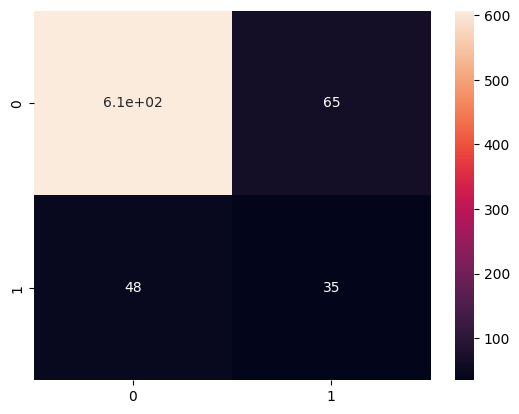

In [255]:
sns.heatmap(confusion_matrix(test_y, model.predict(test_X)), annot=True)

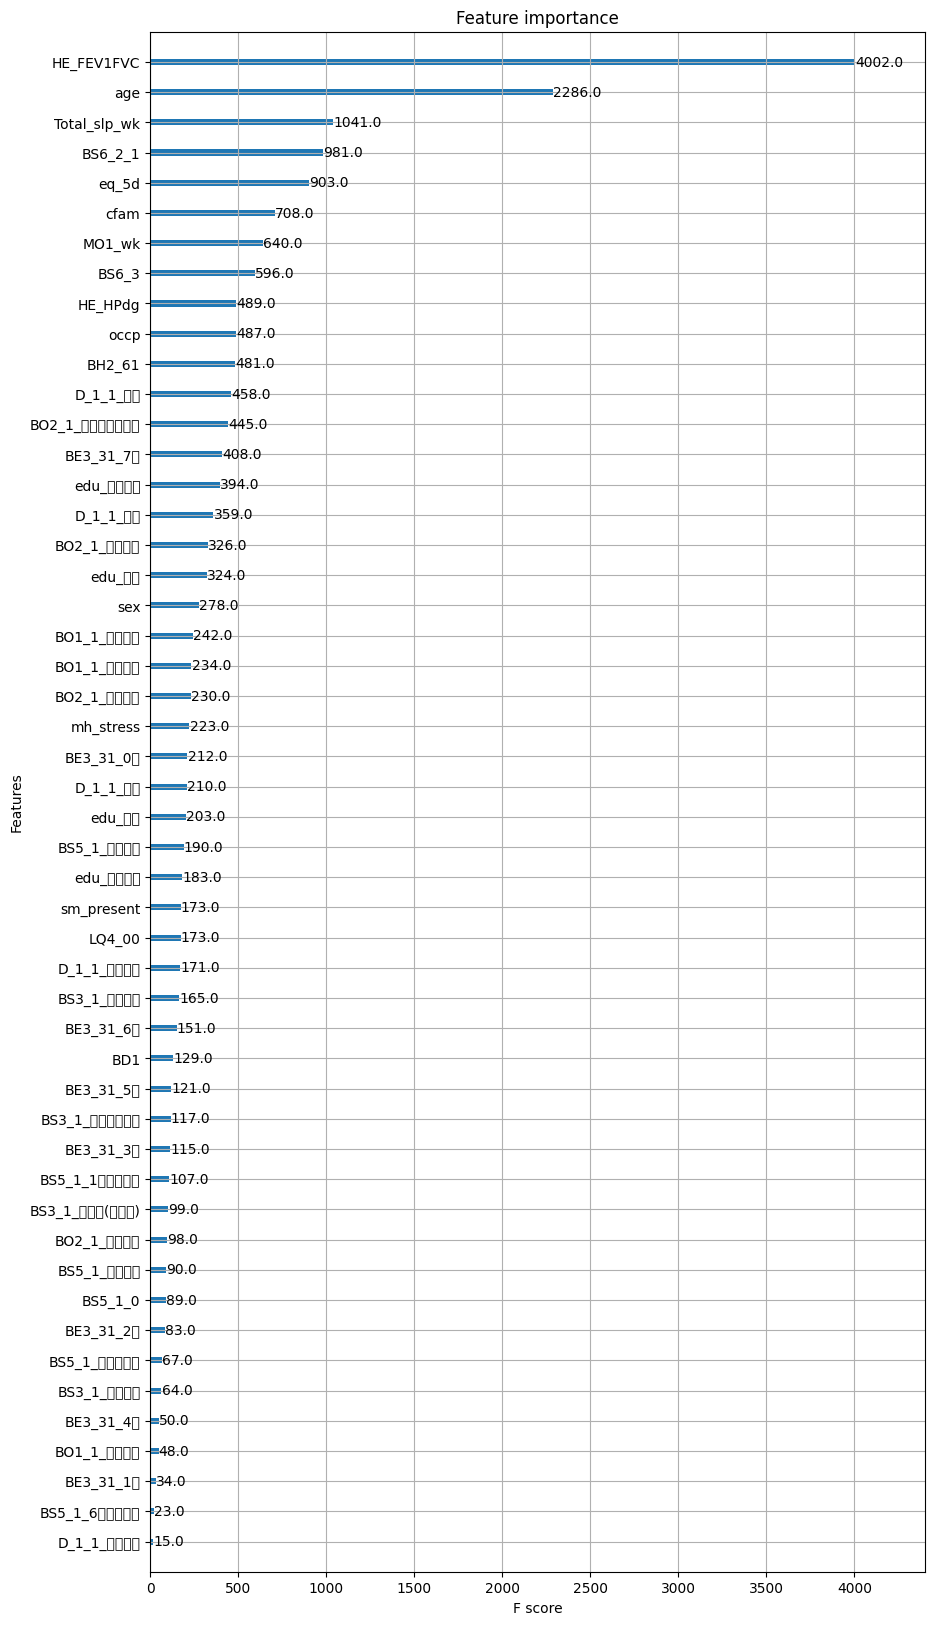

In [256]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_importance(model, ax=ax)
plt.show()

In [28]:
adasyn = ADASYN(random_state=42)
ada_X, ada_y = adasyn.fit_resample(train_X.values, train_y)
ada_X = pd.DataFrame(ada_X, columns=train_X.columns)

In [36]:
# with oversampling
params = {
    'n_estimators': 214,
    'max_depth': 11,
    'learning_rate': 0.008250941591248189,
    'gamma': 16.64826130680066,
    'alpha': 1.1608605891924437,
    'lambda': 19.058117440056236,
    'min_child_weight': 0.030022701631875814,
    'max_delta_step': 39,
    'subsample': 0.4305254632767998,
    'sampling_method': 'uniform',
    'tree_method': 'hist',
    'grow_policy': 'depthwise',
    'max_bin': 367,
    'scale_pos_weight': 1
}
model = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **params)
model.fit(ada_X, ada_y)

XGBClassifier(alpha=1.1608605891924437, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=16.64826130680066, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=19.058117440056236, learning_rate=0.008250941591248189,
              max_bin=367, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=39, max_depth=11, max_leaves=None,
              min_child_weight=0.030022701631875814, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=214,
              n_jobs=None, ...)

In [37]:
print(classification_report(ada_y, model.predict(ada_X)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2688
           1       0.89      0.84      0.86      2696

    accuracy                           0.87      5384
   macro avg       0.87      0.87      0.87      5384
weighted avg       0.87      0.87      0.87      5384



In [38]:
print(classification_report(train_y, model.predict(train_X)))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2688
           1       0.35      0.47      0.40       332

    accuracy                           0.85      3020
   macro avg       0.64      0.68      0.66      3020
weighted avg       0.87      0.85      0.86      3020



In [39]:
print(classification_report(test_y, model.predict(test_X)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       672
           1       0.29      0.39      0.33        83

    accuracy                           0.83       755
   macro avg       0.61      0.64      0.62       755
weighted avg       0.85      0.83      0.84       755

